In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

from scipy import stats
from sklearn.impute import KNNImputer, SimpleImputer
#from google.colab import files
from pandas.api.types import CategoricalDtype
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

In [3]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import gc

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
#import io
#uploaded = files.upload()
#df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

#import io 
#uploaded2 = files.upload() 
#df_test = pd.read_csv(io.BytesIO(uploaded2['test.csv']))

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [6]:
summary = resumetable(df_train)
summary

Dataset Shape: (600000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,600000,0,1,2,19.19
1,bin_0,float64,17894,2,0,1,0,0.44
2,bin_1,float64,18003,2,0,1,1,0.69
3,bin_2,float64,17930,2,0,0,0,0.85
4,bin_3,object,18014,2,F,F,F,0.95
5,bin_4,object,18047,2,N,Y,N,1.00
6,nom_0,object,18252,3,Red,Red,Red,1.31
7,nom_1,object,18156,6,Trapezoid,Star,NaN,2.27
8,nom_2,object,18035,6,Hamster,Axolotl,Hamster,2.27
9,nom_3,object,18121,6,Russia,NaN,Canada,2.27


# Concatenating Train and Test

In [7]:
y_train = df_train["target"]

In [8]:
train_ID = df_train['id']
test_ID = df_test['id']

df_train.drop("id", axis = 1, inplace = True)
df_test.drop("id", axis = 1, inplace = True)

In [9]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['target'], axis=1, inplace=True)
all_data.shape[0]

C:\Users\samar\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


1000000

# Data Visualization

In [10]:
bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

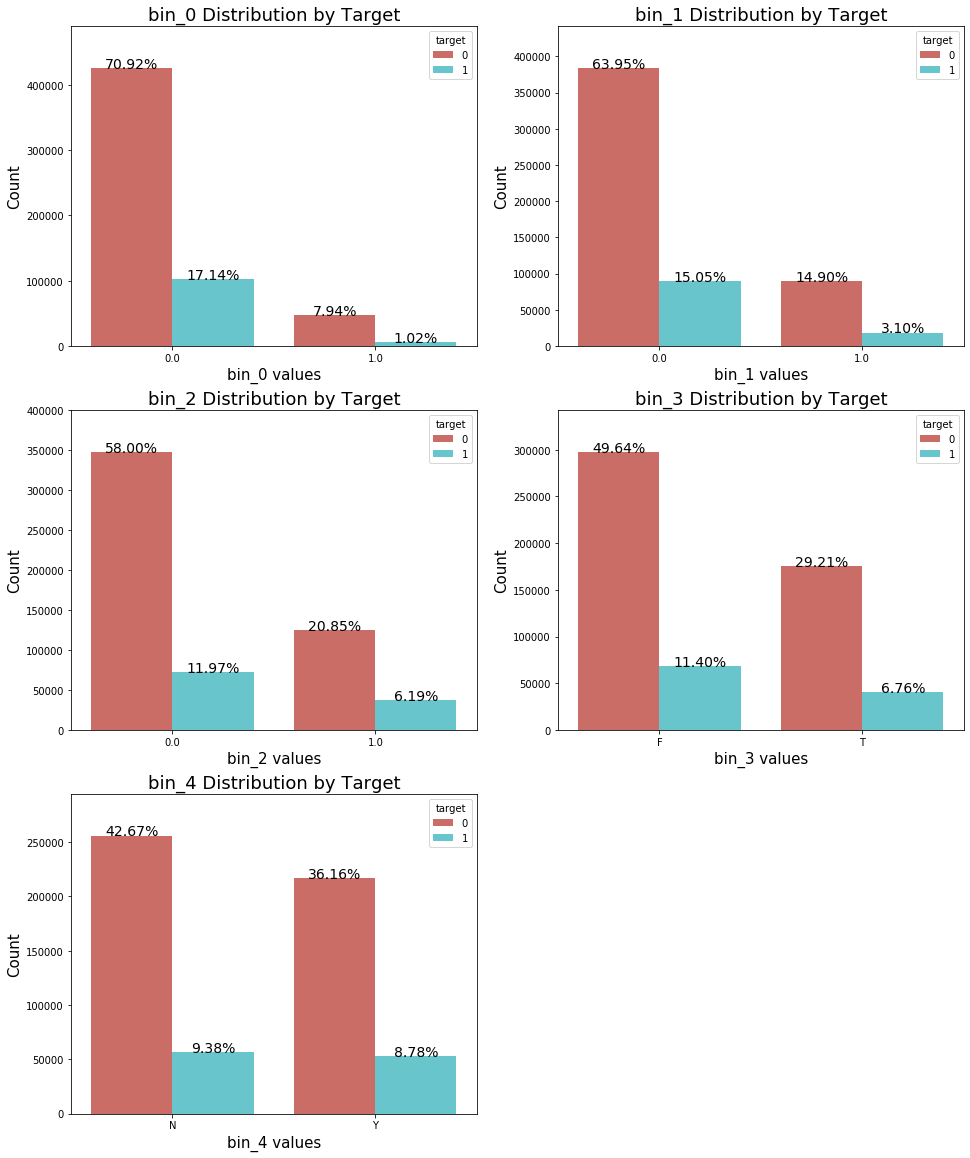

In [11]:
#Looking the V's features
total = len(df_train)

import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 2) # The grid of chart
plt.figure(figsize=(16,20)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(df_train[bin_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=df_train, hue='target', palette='hls') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights
    
plt.show()

In [12]:
nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

In [13]:
def ploting_cat_fet(df, cols, vis_row=5, vis_col=2):
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35)) # size of figure

    # loop to get column and the count of plots
    for n, col in enumerate(df_train[cols]): 
        tmp = pd.crosstab(df_train[col], df_train['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=df_train, order=list(tmp[col].values) , color='green') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

        # twinX - to build a second yaxis
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()

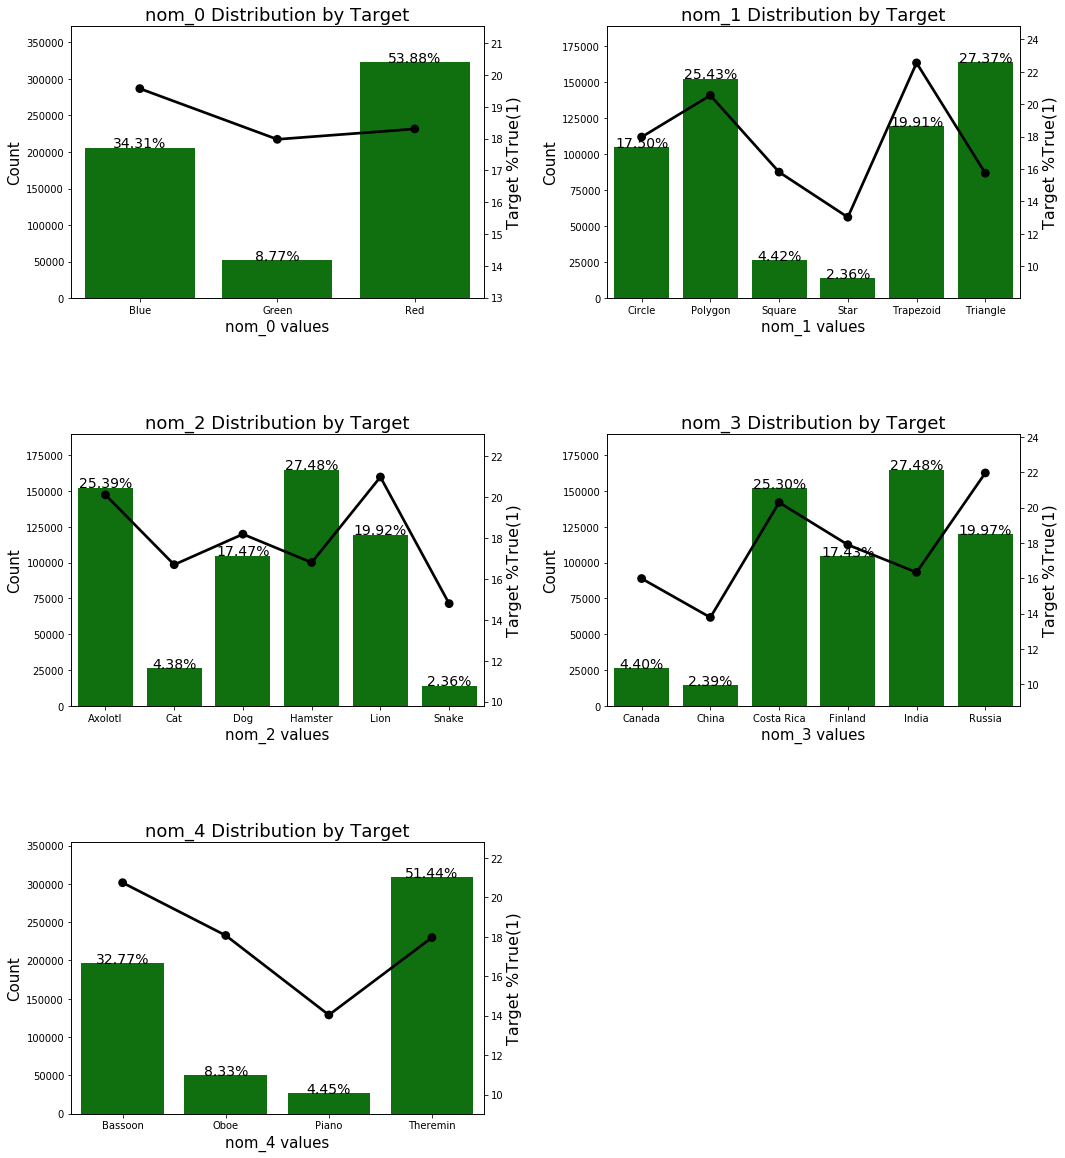

In [14]:
ploting_cat_fet(df_train, nom_cols, vis_row=5, vis_col=2)

In [15]:
ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']

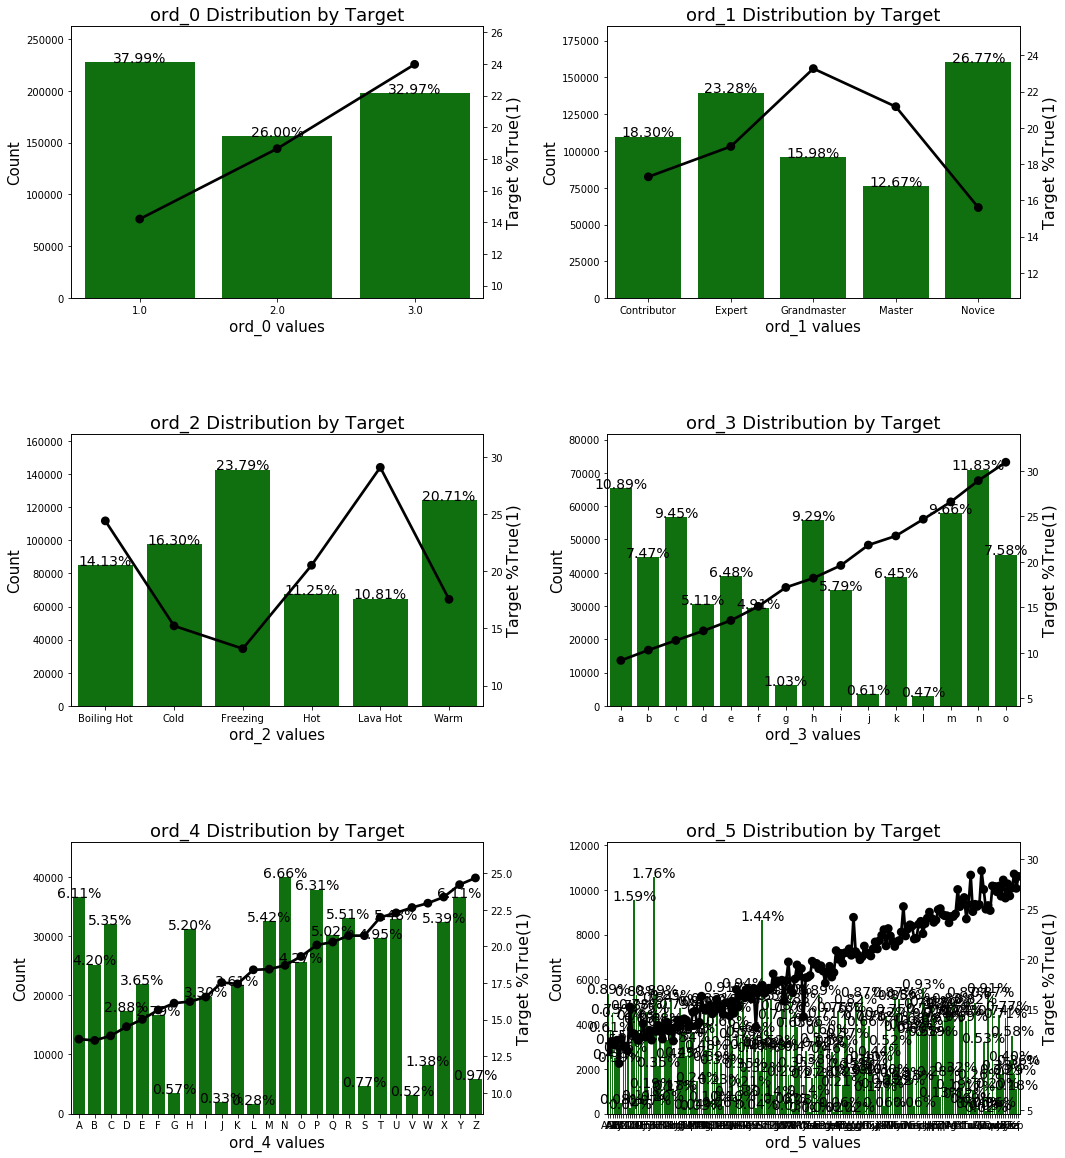

In [16]:
ploting_cat_fet(df_train, ord_cols, vis_row=5, vis_col=2)

In [17]:
df_train['ord_5_ot'] = 'Others'
df_train.loc[df_train['ord_5'].isin(df_train['ord_5'].value_counts()[:25].sort_index().index), 'ord_5_ot'] = df_train['ord_5']

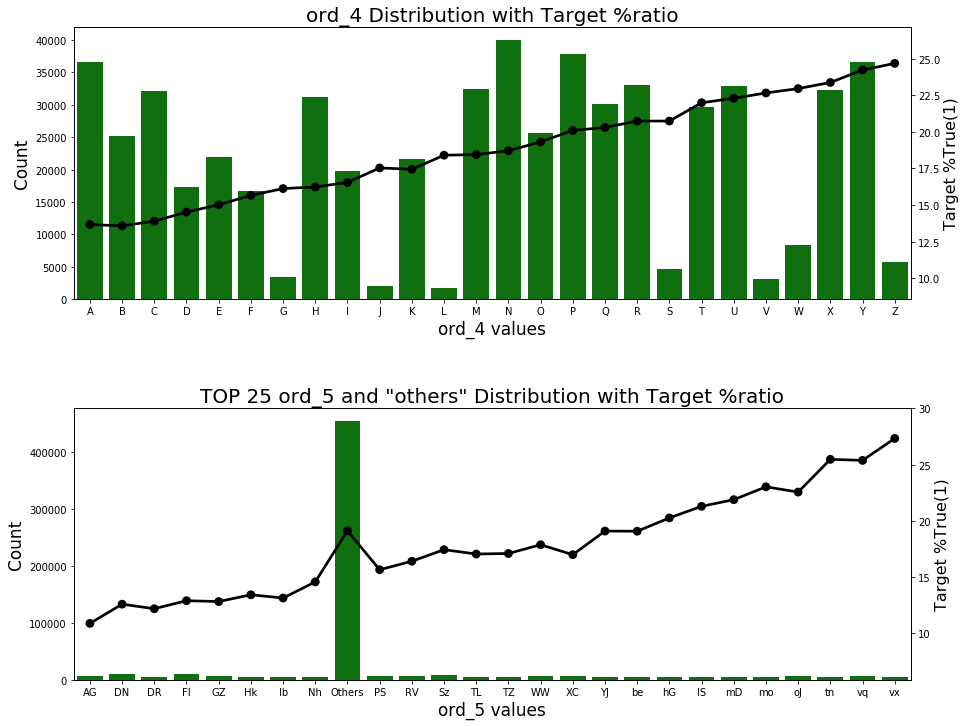

In [18]:
tmp = pd.crosstab(df_train['ord_4'], df_train['target'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)
plt.figure(figsize=(15,12))

plt.subplot(211)
ax = sns.countplot(x='ord_4', data=df_train, order=list(tmp['ord_4'].values) , color='green') 
ax.set_ylabel('Count', fontsize=17) # y axis label
ax.set_title('ord_4 Distribution with Target %ratio', fontsize=20) # title label
ax.set_xlabel('ord_4 values', fontsize=17) # x axis label
# twinX - to build a second yaxis
gt = ax.twinx()
gt = sns.pointplot(x='ord_4', y='Yes', data=tmp,
                   order=list(tmp['ord_4'].values),
                   color='black', legend=False)
gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
gt.set_ylabel("Target %True(1)", fontsize=16)

tmp = pd.crosstab(df_train['ord_5_ot'], df_train['target'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

plt.subplot(212)
ax1 = sns.countplot(x='ord_5_ot', data=df_train,
                   order=list(df_train['ord_5_ot'].value_counts().sort_index().index) ,
                   color='green') 
ax1.set_ylabel('Count', fontsize=17) # y axis label
ax1.set_title('TOP 25 ord_5 and "others" Distribution with Target %ratio', fontsize=20) # title label
ax1.set_xlabel('ord_5 values', fontsize=17) # x axis label
# twinX - to build a second yaxis
gt = ax1.twinx()
gt = sns.pointplot(x='ord_5_ot', y='Yes', data=tmp,
                   order=list(df_train['ord_5_ot'].value_counts().sort_index().index),
                   color='black', legend=False)
gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
gt.set_ylabel("Target %True(1)", fontsize=16)

plt.subplots_adjust(hspace = 0.4, wspace=.3)

plt.show()

In [19]:
ord_5_count = df_train['ord_5'].value_counts().reset_index()['ord_5'].values

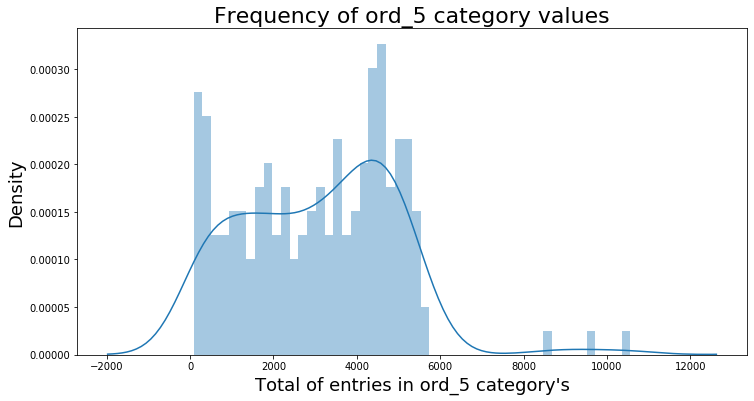

In [20]:
plt.figure(figsize=(12,6))

g = sns.distplot(ord_5_count, bins= 50)
g.set_title("Frequency of ord_5 category values", fontsize=22)
g.set_xlabel("Total of entries in ord_5 category's", fontsize=18)
g.set_ylabel("Density", fontsize=18)

plt.show()

In [21]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 23 columns):
bin_0    970205 non-null float64
bin_1    969959 non-null float64
bin_2    970098 non-null float64
bin_3    970035 non-null object
bin_4    970002 non-null object
day      970023 non-null float64
month    970028 non-null float64
nom_0    969686 non-null object
nom_1    969897 non-null object
nom_2    969786 non-null object
nom_3    969703 non-null object
nom_4    969972 non-null object
nom_5    970310 non-null object
nom_6    969857 non-null object
nom_7    969994 non-null object
nom_8    970289 non-null object
nom_9    969867 non-null object
ord_0    969819 non-null float64
ord_1    969792 non-null object
ord_2    969820 non-null object
ord_3    970031 non-null object
ord_4    970137 non-null object
ord_5    970240 non-null object
dtypes: float64(6), object(17)
memory usage: 175.5+ MB


# Re-engineering Feature Variables

In [22]:
all_data['day_sin'] = np.sin(2 * np.pi * all_data['day']/6.0)
all_data['day_cos'] = np.cos(2 * np.pi * all_data['day']/6.0)

all_data['month_sin'] = np.sin(2 * np.pi * all_data['month']/11.0)
all_data['month_cos'] = np.cos(2 * np.pi * all_data['month']/11.0)

all_data = all_data.drop(['day', 'month'], axis=1)

In [23]:
bin_dict = {'T':1, 'F':0, 'Y':1, 'N':0}
all_data['bin_3'] = all_data['bin_3'].map(bin_dict)
all_data['bin_4'] = all_data['bin_4'].map(bin_dict)

In [24]:
all_data = pd.get_dummies(all_data, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],\
                          prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], drop_first=True, dummy_na=True)

In [25]:
ord_1 = CategoricalDtype(categories=['Novice', 'Contributor','Expert', 
                                     'Master', 'Grandmaster'], ordered=True)
ord_2 = CategoricalDtype(categories=['Freezing', 'Cold', 'Warm', 'Hot',
                                     'Boiling Hot', 'Lava Hot'], ordered=True)
ord_3 = CategoricalDtype(categories=['a', 'b', 'c', 'd', 'e', 'f', 'g',
                                     'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o'], ordered=True)
ord_4 = CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
                                     'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                                     'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], ordered=True)

In [26]:
# Transforming ordinal Features
all_data.ord_1 = all_data.ord_1.astype(ord_1)
all_data.ord_2 = all_data.ord_2.astype(ord_2)
all_data.ord_3 = all_data.ord_3.astype(ord_3)
all_data.ord_4 = all_data.ord_4.astype(ord_4)

In [27]:
all_data.ord_1 = all_data.ord_1.cat.codes
all_data.ord_2 = all_data.ord_2.cat.codes
all_data.ord_3 = all_data.ord_3.cat.codes
all_data.ord_4 = all_data.ord_4.cat.codes

In [28]:
global testCounter
testCounter = 0

In [29]:
def addfn(x):
    if type(x) == float:
        return np.nan
    else:
        return sum([(string.ascii_letters.find(letter)+1) for letter in x])

def joinfn(x):
    if type(x) == float:
        return np.nan
    else:
        return float(''.join(str(string.ascii_letters.find(letter)+1) for letter in x))

def oe1fn(x):
    if type(x) == float:
        return np.nan
    else:
        return string.ascii_letters.find(x[0])+1
        
def oe2fn(x):
    if type(x) == float:
        return np.nan
    else:
        return string.ascii_letters.find(x[1])+1

In [30]:
all_data['ord_5_oe_add'] = all_data['ord_5'].apply(addfn)
all_data['ord_5_oe_join'] = all_data['ord_5'].apply(joinfn)

all_data['ord_5_oe1'] = all_data['ord_5'].apply(oe1fn)
all_data['ord_5_oe2'] = all_data['ord_5'].apply(oe2fn)

for col in ['ord_5_oe1', 'ord_5_oe2', 'ord_5_oe_add', 'ord_5_oe_join']:
    all_data[col]= all_data[col].astype('float64')

In [31]:
all_data[['ord_5', 'ord_5_oe_add', 'ord_5_oe_join', 'ord_5_oe1', 'ord_5_oe2']].head()

,ord_5,ord_5_oe_add,ord_5_oe_join,ord_5_oe1,ord_5_oe2
0,Pw,65.0,4223.0,42.0,23.0
1,pE,47.0,1631.0,16.0,31.0
2,eN,45.0,540.0,5.0,40.0
3,NaN,NaN,NaN,NaN,NaN
4,OZ,93.0,4152.0,41.0,52.0


In [32]:
high_card_feats = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

In [33]:
def hashfn(x):
    if type(x) == float:
        return np.nan
    else:
        return (hash(str(x)) % 5000) 
for col in high_card_feats:
    all_data[f'hash_{col}'] = all_data[col].apply(hashfn)    

In [34]:
def freqfn(x, col):
    if type(x) == float:
        return np.nan
    else:
        #enc_nom_1 = (all_data.groupby(col).size()) / len(all_data)
        return enc_nom_1[x]
    
for col in high_card_feats:
    enc_nom_1 = (all_data.groupby(col).size()) / len(all_data)
    all_data[f'freq_{col}'] = all_data[col].apply(lambda x: freqfn(x, col))

In [35]:
for f in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
    if all_data[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(all_data[f].values))
        all_data[f'le_{f}'] = lbl.transform(list(all_data[f].values))

In [36]:
def hexfn(x):
    if type(x) == float:
        return np.nan
    else:
        return int(x, 16)

for col in high_card_feats:
    all_data[f'hex_{col}'] = all_data[col].apply(hexfn)

In [37]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 69 columns):
bin_0               970205 non-null float64
bin_1               969959 non-null float64
bin_2               970098 non-null float64
bin_3               970035 non-null float64
bin_4               970002 non-null float64
nom_5               970310 non-null object
nom_6               969857 non-null object
nom_7               969994 non-null object
nom_8               970289 non-null object
nom_9               969867 non-null object
ord_0               969819 non-null float64
ord_1               1000000 non-null int8
ord_2               1000000 non-null int8
ord_3               1000000 non-null int8
ord_4               1000000 non-null int8
ord_5               970240 non-null object
day_sin             970023 non-null float64
day_cos             970023 non-null float64
month_sin           970028 non-null float64
month_cos           970028 non-null float64
nom_0_Green         10

In [38]:
all_data.drop([ 'ord_5', 'hash_nom_5', 
                'hash_nom_6', 'hash_nom_7', 'hash_nom_8', 'hash_nom_9',
               #'le_nom_5', 'le_nom_6', 'le_nom_7', 'le_nom_8', 'le_nom_9',
               #'freq_nom_5','freq_nom_6', 'freq_nom_7', 'freq_nom_8', 'freq_nom_9',
                'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'
              ], axis=1, inplace=True)

#'feq_nom_5', 'feq_nom_6', 'feq_nom_7', 'feq_nom_8', 'feq_nom_9', 

# Imputing missing vlaues

In [39]:
imputer = SimpleImputer()

In [40]:
mean_filled_data = imputer.fit_transform(all_data)
mean_filled_data = pd.DataFrame(mean_filled_data)

In [41]:
mean_filled_data.columns = all_data.columns

In [42]:
mean_filled_data['bin_1'].describe()

count    1000000.000000
mean           0.186181
std            0.383362
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000
Name: bin_1, dtype: float64

In [43]:
mean_filled_data.bin_1.unique()

array([0.        , 1.        , 0.18618107])

# Seperating Train and Test

In [44]:
train = mean_filled_data[:ntrain]
test =  mean_filled_data[ntrain:]

In [45]:
train.shape[0]

600000

# Loading Estimator Libraries

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

#Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

clfs = []
seed = 42

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier", XGBClassifier()))

# clfs.append(("KNN", 
#              Pipeline([("Scaler", StandardScaler()),
#                        ("KNN", KNeighborsClassifier(n_neighbors=5))])))

clfs.append(("DecisionTreeClassifier", DecisionTreeClassifier()))

clfs.append(("RandomForestClassifier", RandomForestClassifier(n_estimators=100)))

clfs.append(("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=100)))

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",ExtraTreesClassifier()))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'roc_auc'
n_folds = 7

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, shuffle=False, random_state=seed)
    
    cv_results = cross_val_score(model, 
                                 train.values, y_train, 
                                 cv= kfold, scoring=scoring,
                                 n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20) 
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.show()

# XGBoost

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 12
    count=1
    kf = KFold(n_splits=FOLDS, shuffle=False, random_state=42)

    # tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(submission.shape[0])
    # y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in kf.split(train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=500, random_state=4, 
            verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = train.iloc[tr_idx, :], train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    
    return -(score_mean / FOLDS)

space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 200, 5))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [.5, 0.6, 0.7, .8]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30, 
            # trials=trials
           )

In [48]:
okish_params = {'max_depth': 4, 'gamma': '0.577', 'subsample': '0.80', 'reg_alpha': '0.187', 'reg_lambda': '0.089', 'learning_rate': '0.138', 'num_leaves': '120.000', 'colsample_bytree': '0.783', 'min_child_samples': '220.000', 'feature_fraction': '0.670', 'bagging_fraction': '0.565'}

best_params = space_eval(space, best)
best_params['max_depth'] = int(best_params['max_depth'])
best_params

In [49]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    **okish_params,
    tree_method='gpu_hist'
)

clf.fit(train, y_train)

y_preds = clf.predict_proba(test)[:,1] 

In [50]:
feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

,score
freq_nom_8,624
freq_nom_7,608
le_nom_8,416
le_nom_7,384
freq_nom_9,317
ord_5_oe1,284
freq_nom_5,282
ord_3,278
le_nom_9,252
hex_nom_7,248


In [52]:
submission['target'] = y_preds 
submission.to_csv('XGB_hypopt_model2.csv', index=False, header =1)

In [ ]:
submission.head()